In [2]:

import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

import tensorflow as tf


2021-10-18 13:37:58.972168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-18 13:37:58.972194: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
BATCH_SIZE = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

this_folder = os.path.abspath("")
DATA_FOLDER = os.path.join(this_folder, "data", "scenario1", "split")
MODELS_FOLDER = os.path.join(this_folder, "models")
os.listdir(DATA_FOLDER)

['val', 'train', 'test']

In [4]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

2021-10-18 13:38:02.746336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-18 13:38:02.746362: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-18 13:38:02.746382: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (frcaud-Latitude-7420): /proc/driver/nvidia/version does not exist
2021-10-18 13:38:02.746547: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    os.path.join(DATA_FOLDER, 'train'),
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)
class_names = train_dataset.class_names
print(class_names)

Found 569 files belonging to 5 classes.
['0_Negative', '1_Primordial', '2_Primary', '3_Secondary', '4_Tertiary']


In [6]:
test_dataset = image_dataset_from_directory(
    os.path.join(DATA_FOLDER, 'test'),
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 78 files belonging to 5 classes.


In [7]:
val_dataset = image_dataset_from_directory(
    os.path.join(DATA_FOLDER, 'val'),
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 120 files belonging to 5 classes.


In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2021-10-18 13:38:12.424625: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-18 13:38:12.447640: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1804800000 Hz


(10, 7, 7, 1280)


In [10]:
base_model.trainable = False

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 5)


In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405  

In [17]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset)

Epoch 1/30
57/57 [==============================] - 11s 151ms/step - loss: 1.6440 - sparse_categorical_accuracy: 0.3656 - val_loss: 1.3371 - val_sparse_categorical_accuracy: 0.5083
Epoch 2/30
57/57 [==============================] - 8s 141ms/step - loss: 1.2664 - sparse_categorical_accuracy: 0.4956 - val_loss: 1.0788 - val_sparse_categorical_accuracy: 0.5500
Epoch 3/30
57/57 [==============================] - 12s 199ms/step - loss: 1.0557 - sparse_categorical_accuracy: 0.5870 - val_loss: 0.9223 - val_sparse_categorical_accuracy: 0.6333
Epoch 4/30
57/57 [==============================] - 10s 159ms/step - loss: 0.8901 - sparse_categorical_accuracy: 0.6432 - val_loss: 0.8151 - val_sparse_categorical_accuracy: 0.6833
Epoch 5/30
57/57 [==============================] - 10s 167ms/step - loss: 0.7722 - sparse_categorical_accuracy: 0.6924 - val_loss: 0.7450 - val_sparse_categorical_accuracy: 0.7250
Epoch 6/30
57/57 [==============================] - 10s 163ms/step - loss: 0.7059 - sparse_categ

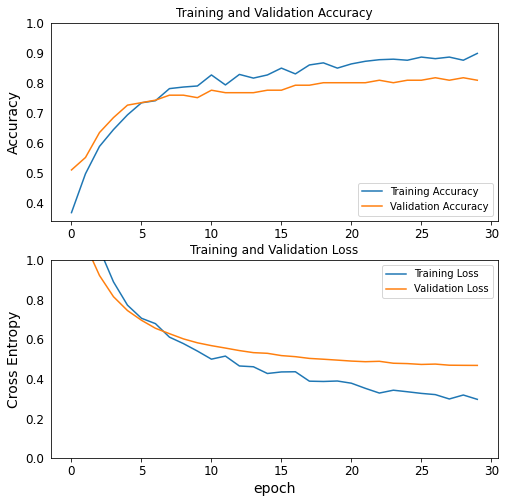

In [18]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = True
plt.rcParams['ytick.labelsize'] = True
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [8, 8]
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

8/8 [==============================] - 1s 85ms/step - loss: 0.4630 - sparse_categorical_accuracy: 0.7949
Test accuracy : 0.7948718070983887


In [20]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = np.argmax(predictions, axis=1)
print('predictions:', predictions)
print('truth:      ', label_batch)

predictions: [0 0 2 0 4 0 2 0 3 0]
truth:       [0 0 2 0 3 3 0 0 3 0]


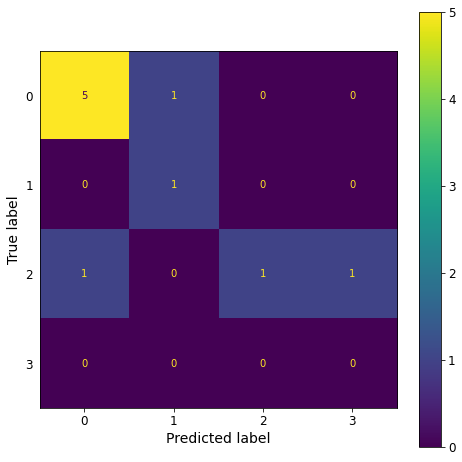

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_mat = confusion_matrix(label_batch, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot()
plt.show()

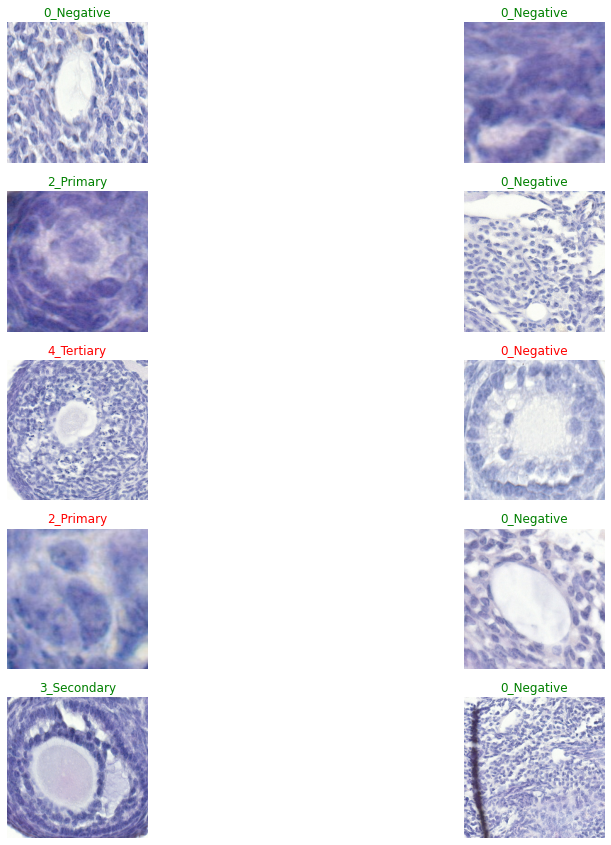

In [22]:
plt.figure(figsize=(15, 15))
for i in range(10):
  ax = plt.subplot(5, 2, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  if predictions[i] != label_batch[i]:
    color = 'red'
  else:
    color = 'green'
  plt.title(class_names[predictions[i]], color=color)
  plt.axis("off")

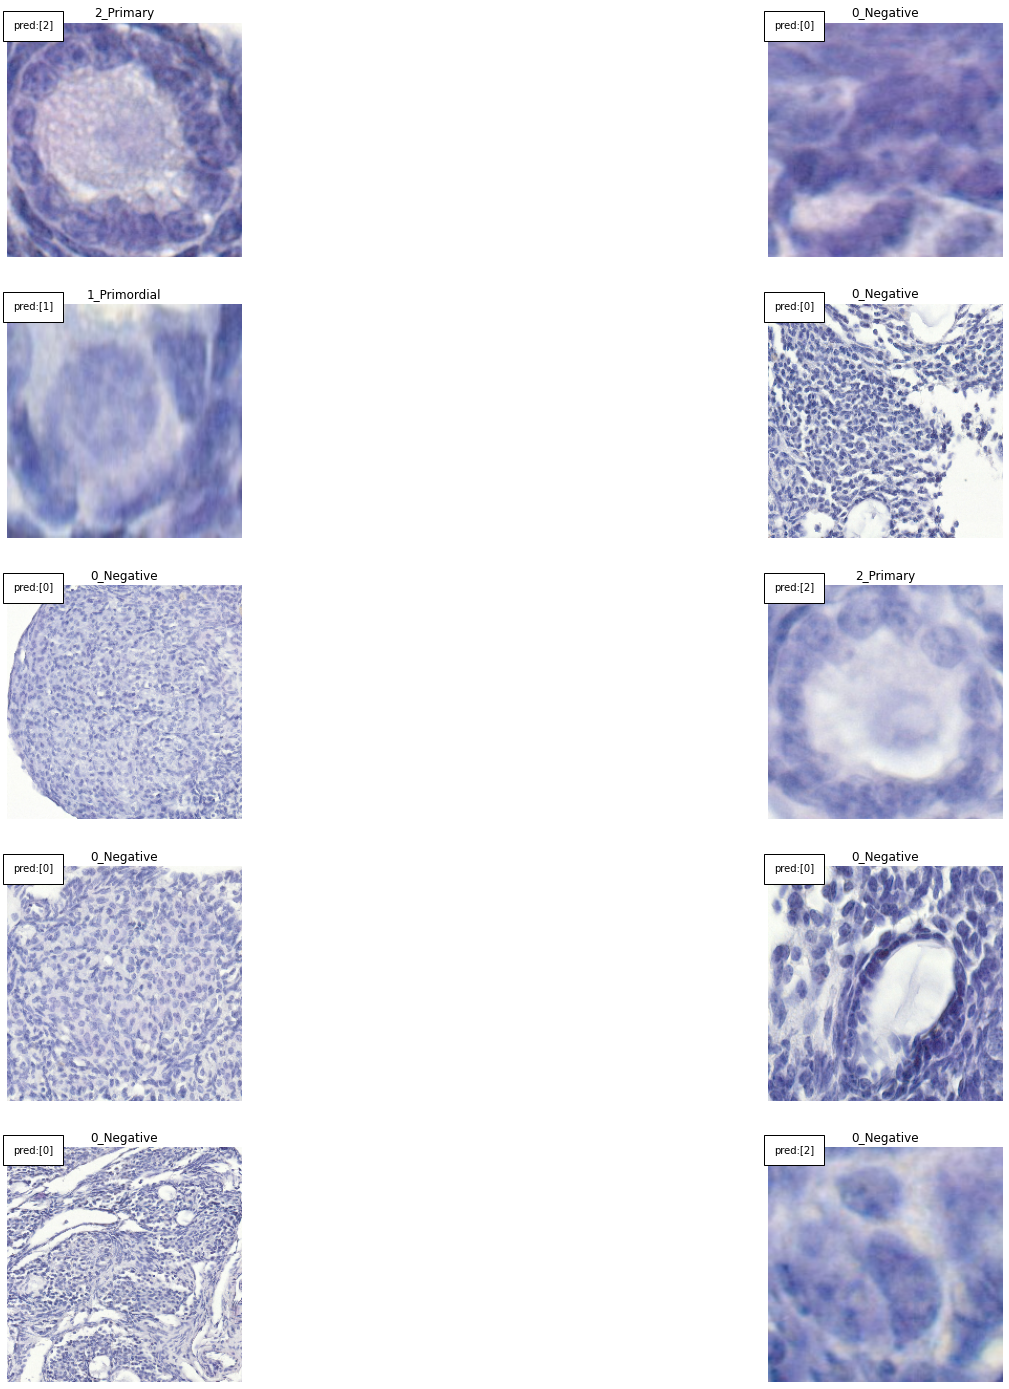

In [23]:
for images, labels in test_dataset.take(1):
    plt.figure(figsize=(25,25))
    for i in range(10):
        ax = plt.subplot(5, 2, i+1)
        ax.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        pred = model.predict(tf.reshape(images[i], (1, 224, 224, 3)))
        pred = np.argmax(pred, axis=1)
        ax.text(5,5,f'pred:{pred}', bbox={'facecolor': 'white', 'pad': 10})
        plt.axis("off")

In [24]:
model.save(os.path.join(MODELS_FOLDER, "classifier"))

2021-10-18 13:45:05.992045: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/frcaud/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/frcaud/frcaud/follicles_detection/models/classifier/assets


In [25]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_FOLDER, "classifier"))
model_loaded

In [26]:
def predict_image(image, model):
    image = image.resize((224,224))
    image = np.array(image)
    image = tf.reshape(image, (1,224,224,3))
    pred = model.predict(image)
    return np.argmax(pred), np.max(pred)


In [27]:
im = Image.open("test/3_Secondary/D-1M03-6.tiff-Secondary-x.min7795-y.min8560-x.max8721-y.max9447.jpg")
predict_image(im, model_loaded)

(3, 0.9126505)

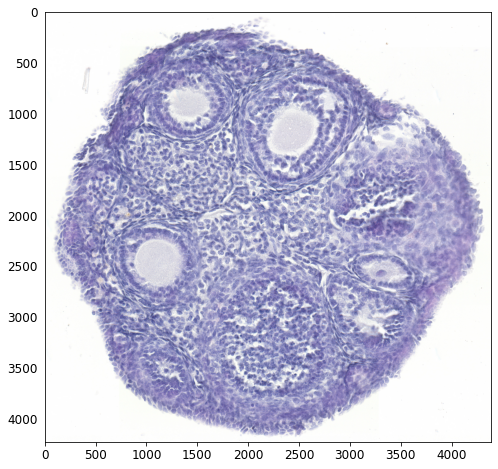

In [28]:
coupe = Image.open('data/D-1M01-2.jpg')
plt.imshow(coupe)

(3, 0.97886515)

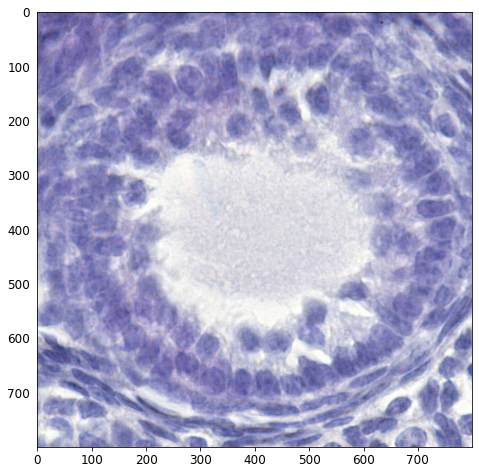

In [29]:
im1 = coupe.crop((1000,500,1800,1300))
plt.imshow(im1)
predict_image(im1, model_loaded)

(0, 0.9828389)

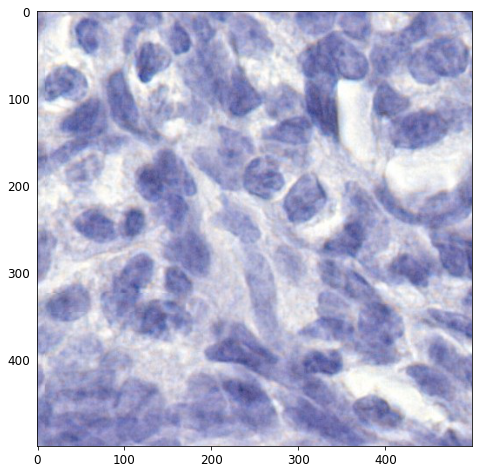

In [30]:
im2 = coupe.crop((2000,2000,2500,2500))
plt.imshow(im2)
predict_image(im2, model_loaded)

(2, 0.8257673)

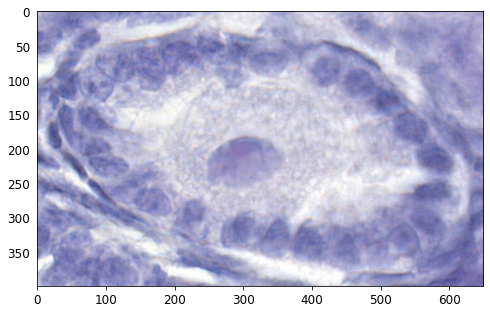

In [31]:
im3 = coupe.crop((3000,2350,3650,2750))
plt.imshow(im3)
predict_image(im3, model_loaded)

(0, 0.9804437)

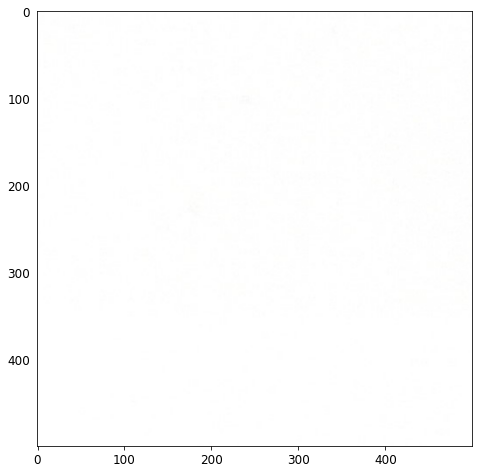

In [32]:
im4 = coupe.crop((0,0,500,500))
plt.imshow(im4)
predict_image(im4, model_loaded)